# Install And Import...

#** PIP INSTALL block**

Installing all required libraries.

In [1]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install sympy
!pip install fpdf
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=45c2fe739024ae315bbb816e4b84bd4d87280bc06fc4e00e71dc3416ef5ce8d7
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


Installing LLM Models

In [34]:
!pip install llama-stack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9c902b23523bfbc2b51a1d7c89f5453af2bd9cfe94f8ab8d28ecc001be0e905c
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [35]:
llama model list

SyntaxError: invalid syntax (<ipython-input-35-9f2d364b119d>, line 1)

# **# Import block**

Importing all required libraries.

In [2]:
from google.colab import auth

import gspread
from google.auth import default

import pandas as pd
from fuzzywuzzy import process, fuzz
import re
from fpdf import FPDF
from google.colab import drive
import shutil

from google.colab import drive

import subprocess

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

# Authorizing Google User

In [3]:
auth.authenticate_user()

# Authorizing GoogleSpreed
 to import data from Questionnaire response

In [4]:

  creds, _ = default()

gs = gspread.authorize(creds)

# Mounting Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# Storing the whole sheet in "worksheetPrime"

In [6]:
worksheetPrime = gs.open('Questionnaire 1  (Responses)').sheet1

# IDK what it is

In [7]:
#Function to replace similar names with the most frequent one
def correct_spelling_fuzzy(df, freq_dist, similarity_threshold=85):
    # Create a copy of the DataFrame to avoid modifying the original
    corrected_colleges = df['College Name '].copy()

    # List to store which names are already corrected
    corrected = {}

    # Iterate over unique college names in the frequency table
    for college in freq_dist.index:
        if college in corrected:
            # If this college name has already been corrected, skip it
            continue

        # Find similar names using fuzzy matching
        similar_colleges = process.extract(college, freq_dist.index, scorer=fuzz.token_sort_ratio)


        # Filter names that are similar based on the threshold
        similar_colleges = [name for name, score in similar_colleges if score >= similarity_threshold]
        #print("%%%%%%%%%%%%%%%%%%")
        ##print(similar_colleges)
        #print("%%%%%%%%%%%%%%%%%%")
        # Get the most frequent similar name
        most_frequent_college = max(similar_colleges, key=lambda name: freq_dist[name])
        #print(most_frequent_college)

        # Replace all similar names with the most frequent one
        for similar in similar_colleges:
            corrected[similar] = most_frequent_college
            corrected_colleges.replace(similar, most_frequent_college, inplace=True)

    return corrected_colleges

# DATA CLEAN : LVL 1

1) Converting the shhet to DataFrame

2) Cleaning the Column : College Name

3) Creting Freq Dist. Table for **College Name and it's count**

In [8]:

rows = worksheetPrime.get_all_values()
df = pd.DataFrame(rows).reset_index(drop=True)
df.columns = df.iloc[0]

df.drop(columns=['Timestamp', 'Email address','Name\n'], inplace=True)

# Calculate frequency distribution
freq_dist = df['College Name '].value_counts()

df['College Name '] = df['College Name '].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
df['College Name '] = correct_spelling_fuzzy(df, freq_dist)

college_mapping = {
    'iem': 'institute of engineering and management',
    #'institute of engineering and management kolkata':'institute of engineering and management',
    #'iem salt lake': 'institute of engineering and management',
    #'amity university kolkata': 'amity university',
    'techno international new town': 'techno international',
    'techno international newtown':'techno international',
    'calcutta university':'university of calcutta',
    'snu': 'sister nivedita university',
    'university of engineering  management':'university of engineering and management',
    'thk jain':'Tara Devi Harakh Chand Kankaria Jain College'.lower(),
    'fiem':'Future Institute of Engineering and Management'.lower(),
    "st. xavier's college, kolkata" : "st. xavier's college",
    "st xaviers college kolkata" : "st xaviers college",
    "st xaviers autonomous kolkata" : "st xaviers college",
    'st xaviers universitykolkata':"st xaviers university",
    'techno india':'techno india university',
    'besc':'the bhawanipur educational society college',
    'the bhawanipur educational society':'the bhawanipur educational society college',
    "the bhawanipore education society":"the bhawanipur educational society college",
    'techno main salt lake':'techno india university',
    'the bhawanipur college':'the bhawanipur educational society college',
    'drsudhir chandra sur institute of technology and sports complex':'dr sudhir chandra sur institute of technology and sports complex',
    #'rkmrc':'Ramakrishna Mission Residential College'.lower(),
    'auk':'amity university'

}
df['College Name '] = df['College Name '].map(college_mapping).fillna(df['College Name '])

df['College Name '] = df['College Name '].replace(r'.*institute of engineering and management.*', 'institute of engineering and management', regex=True)
df['College Name '] = df['College Name '].replace(r'.*university of calcutta.*', 'university of calcutta', regex=True)

df['College Name '] = df['College Name '].replace(r'.*xaviers.*college.*', 'st xaviers college (autonomous)', regex=True)
df['College Name '] = df['College Name '].replace(r'.*xaviers university.*', 'st xaviers university', regex=True)
df['College Name '] = df['College Name '].replace(r'.*iem.*', 'institute of engineering and management', regex=True)
df['College Name '] = df['College Name '].replace(r'.*amity.*', 'amity university', regex=True)
df['College Name '] = df['College Name '].replace(r'.*sivanth sastri*', 'sivnath sastri college', regex=True)
df['College Name '] = df['College Name '].replace(r'.*west bengal national university of juridical sciences*', 'the west bengal national university of juridical sciences', regex=True)
df['College Name '] = df['College Name '].replace(r'.*university of engineering and management .*', 'university of engineering and management', regex=True)
df['College Name '] = df['College Name '].replace(r'.*rkmrc.*', 'Ramakrishna Mission Residential College'.lower(), regex=True)
df['College Name '] = df['College Name '].replace(r'.*presidency university.*', 'presidency university'.lower(), regex=True)

df = df[df['College Name '] != 'drop out']  #drop out students are not taking under population so do in sample.

frequency_table = df[df['College Name ']!= 'college name']['College Name '].value_counts()
print(frequency_table)
total_frequency = frequency_table.sum()
#print(df['College Name '].unique())
cOnt=len(df['College Name '].unique())-1
print("No. of colleges:", cOnt)
print("total:",total_frequency )

College Name 
sister nivedita university                         27
institute of engineering and management            16
st xaviers university                              13
techno international                                9
jadavpur university                                 9
                                                   ..
indian institutes of technology madras              1
heritage college                                    1
iiest shibpur                                       1
heritage law college                                1
st thomas college of engineering and technology     1
Name: count, Length: 61, dtype: int64
No. of colleges: 61
total: 191


# Exporting the Freq. Dist Table in PDF format

In [9]:
# Create an instance of FPDF
pdf = FPDF()

# Add a page
pdf.add_page()

# Set the font for the PDF: (font name, style, size)
pdf.set_font("Arial", 'B', 16)

# Add a title
pdf.cell(200, 10, txt="Data to PDF", ln=True, align='C')

# Add another line of text
pdf.set_font("Arial", 'B', 12)

pdf.set_font("Arial", 'B', 12)
pdf.cell(140, 10, 'College Name', border=1, align='C')
pdf.cell(50, 10, 'Frequency', border=1, ln=True, align='C')

# Set font for table body
pdf.set_font("Arial", '', 12)

# Add frequency table rows to the PDF in a well-aligned table format
for index, value in frequency_table.items():
    pdf.cell(140, 10, index, border=1)  # College name column
    pdf.cell(50, 10, str(value), border=1, ln=True)  # Frequency column

# Add total frequency and number of unique colleges
pdf.ln(10)
pdf.set_font("Arial", 'B', 12)
pdf.cell(140, 10, 'No. of colleges:', border=1)
pdf.cell(50, 10, str(cOnt), border=1, ln=True)

pdf.cell(140, 10, 'Total frequency:', border=1)
pdf.cell(50, 10, str(total_frequency), border=1, ln=True)

pdf.output(f'sample_output_@{total_frequency}.pdf')


file_to_upload = f'sample_output_@{total_frequency}.pdf'

# Specify the target folder path in Google Drive (shared folder)
target_folder = '/content/drive/MyDrive/pdf files'

# Copy the file to the shared folder
shutil.copy(file_to_upload, target_folder)

print('File uploaded to shared folder successfully!')

File uploaded to shared folder successfully!


# For Latex, which I haven't used

In [10]:
frequency_df = frequency_table.reset_index()
frequency_df.columns = ['College Name', 'Frequency']

# Convert the DataFrame to LaTeX format
latex_table = frequency_df.to_latex(index=False)

# Print the LaTeX table
#print(latex_table)

latex_code = r'''
\documentclass{article}
\usepackage{booktabs}
\begin{document}
\begin{center}
\textbf{Frequency Table} \\[10pt]
''' + latex_table + r'''
\end{center}
\end{document}
'''



# DATA CLEAN : LVL 2.0
1) Filter data set based on CONSENT

2) Dropping few non-required columns

3) Dropping CONSENT column

4) Renaming Columns as per requirments.

In [11]:
df2=df[df['Do you consent to the use of the information provided in this form for analysis and research purposes? Your data will be handled confidentially and used solely for academic or research objectives. [ Put it on the top]'] == 'Yes, I consent'].reset_index()

df2=df2.drop("How many earning people are there in your family? ", axis=1)

df2=df2.drop("Highest Qualification of your parents", axis=1)

df2=df2.drop("On a scale of 1-5 what will you rate your chosen career as a stable one. [# not required]", axis=1)


df2=df2.drop("Do you consent to the use of the information provided in this form for analysis and research purposes? Your data will be handled confidentially and used solely for academic or research objectives. [ Put it on the top]", axis=1)

df2 = df2.rename(columns={'On scale 1-5 what do you think about the influence from your friends towards you for choosing your career path':'friend_influence','On scale 1-5 what do you think about the influence from your teacher/mentor towards you for choosing your career path':'mentor_influence','On scale 1-5 what do you think your career choice has been affected by social or cultural expectations.':'social_expectations','On a scale of 1-5 how much social media has affected your career choices in recent days.':'social_media_influence','Do you feel that Your choosen degree aligns with your personal choice':'personal_choice','On scale 1-5 what do you think about the influence from your parents towards you for choosing your career path':'parents_influence'})

df2 = df2.rename(columns={'Are you involved with any co-curricular activities? Please mention':'co-curricular activity','What was your motivation/factors behind choosing your current Stream of study?':'motivation','How much you are satisfied with your chosen Stream of study':'satisfaction','How much do you feel this degree is easy for you?':'easy','What is your preferred Working Sector?(E.g.private sector or public sector or IT sector e.t.c)':'preffed sector','Which profession you would like to pursue in future ? (e.g., data scientist , modelling, entrepreneurship) ':'profession','Your current CGPA?':'CGPA','Annual Family Income (appx)':'Family_income','How much can you invest on your in education ? (in lakhs)': 'Spending','What is your expected salary (in Lakhs Per Annum) ':'Expected_salary','By what age do you want to settle in your career?': 'Age','Subject of Specialisation [With which subject you are pursing the degree]': 'Subject', 'Percentage obtained in Class X': 'Percent_10', 'Percentage obtained in Class XII': 'Percent_12','Favourite Subject(s) till Class X and marks obtained in that subject':'fav_marks_X','Favourite Subject(s) till Class XII and marks obtained in that subject':'fav_marks_XII'})


Uploding Filtered dataset (csv) to Drive

In [12]:
df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

# Work on Filtered DataSet
1) Creting Freq Dist. Table for **College Name and it's count**
2) Exporting Freq. Dist. table as PDF

In [13]:
frequency_table2 = df2[df2['College Name ']!= 'college name']['College Name '].value_counts()
print(frequency_table2)
total_frequency = frequency_table2.sum()
#print(df['College Name '].unique())
cOnt=len(df2['College Name '].unique())-1
print("No. of colleges:", cOnt)
print("total:",total_frequency )

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Create an instance of FPDF
pdf2 = FPDF()

# Add a page
pdf2.add_page()

# Set the font for the PDF: (font name, style, size)
pdf2.set_font("Arial", 'B', 16)

# Add a title
pdf2.cell(200, 10, txt="Data to PDF", ln=True, align='C')

# Add another line of text
pdf2.set_font("Arial", 'B', 12)
pdf2.set_font("Arial", 'B', 12)
pdf2.cell(140, 10, 'College Names', border=1, align='C')
pdf2.cell(50, 10, 'Frequency', border=1, ln=True, align='C')

# Set font for table body
pdf2.set_font("Arial", '', 12)

# Add frequency table rows to the PDF in a well-aligned table format
for indexi, value2 in frequency_table2.items():
    pdf2.cell(140, 10, indexi, border=1)  # College name column
    pdf2.cell(50, 10, str(value2), border=1, ln=True)  # Frequency column

# Add total frequency and number of unique colleges
pdf2.ln(10)
pdf2.set_font("Arial", 'B', 12)
pdf2.cell(140, 10, 'No. of colleges:', border=1)
pdf2.cell(50, 10, str(cOnt), border=1, ln=True)

pdf2.cell(140, 10, 'Total frequency:', border=1)
pdf2.cell(50, 10, str(total_frequency), border=1, ln=True)

pdf2.output(f'filter.1_output_@{total_frequency}.pdf')


file_to_upload = f'filter.1_output_@{total_frequency}.pdf'

# Specify the target folder path in Google Drive (shared folder)
target_folder = '/content/drive/MyDrive/pdf files'

# Copy the file to the shared folder
shutil.copy(file_to_upload, target_folder)

print('File uploaded to shared folder successfully!')

College Name 
sister nivedita university                                          26
institute of engineering and management                             16
st xaviers university                                               13
jadavpur university                                                  9
techno international                                                 8
techno india university                                              7
st xaviers college (autonomous)                                      7
presidency university                                                6
maulana azad college                                                 6
asutosh college                                                      5
surendranath college                                                 5
amity university                                                     4
university of engineering and management                             4
university of calcutta                                         

# DATA CLEAN : LVL 2.1
1) Assigning "Genders" : M - Male ; F - Female ; O - Others

2) Dealing With "Subjects of Specilization"

3) Uploading the output(csv) to Drive.

In [14]:
df2['Gender'] = df2['Gender'].apply(lambda x: 'M' if x == 'Male' else 'F' if x == 'Female' else 'O')



df2['Subject'] = df2['Subject'].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
df2['Subject'] = df2['Subject'].replace(r'.*statistic.*', 'Statistics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*computer sc.*', 'computer science engineering', regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*cse.*', 'computer science engineering', regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*pharmacology.*', 'pharmacology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*physics.*', 'Physics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*microbiology .*', 'MicroBiology '.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*mathematics.*', 'Mathematics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*marketing.*', 'Marketing'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*⁠life sciences.*', '⁠Life Sciences'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*aiml.*', 'Computer Science - Artificial intelligence and Machine Learning'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*data science.*', '⁠Computer Science - Data Science '.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*psychology.*', 'Psychology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*journalism and mass communication.*', 'Journalism and Mass communication'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*information technology.*', 'Information Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*laboratory technology.*', 'Medical Laboratory Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*electronics and communication.*', 'Electronics and Communication'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*electrical.*', 'Electrical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*hr.*', 'Human Resource'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*history.*', 'History'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*geography.*', 'Geography'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*fashion.*', 'Fashion Designing'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*economic.*', 'Economics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*data visualization.*', 'Data Visualization'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*computer application.*', 'Computer Application'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*chemical.*','Chemical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*csbs.*', 'Computer Science and Business System'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*biomedical.*', 'Biomedical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*hospital management.*', 'Hospital Management'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*political science.*', 'Political Science'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*english.*', 'English'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*food.*', 'Food Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*analytic.*', 'Analytics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*animation.*', 'Animation'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*agricul.*','Agriculture'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*account.*', 'Accountancy'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*constitutional.*','Constitutional Matters'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*finance', 'Finance'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*management.*', 'Management'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'medical', np.nan)
df2['Subject'] = df2['Subject'].replace(r'engineering', np.nan)
df2['Subject'] = df2['Subject'].replace(r'na', np.nan)
df2['Subject'] = df2['Subject'].replace(r'business',  'Computer Science and Business System'.lower())
df2['Subject'] = df2['Subject'].replace(r'.*computer.*', 'computer science engineering')
df2['Subject'] = df2['Subject'].replace(r'.*instrumentation.*', 'Electronics and Instrumentation Engineering'.lower(), regex=True)
null_list = np.array(['nothing','bcom','llb','law','bachelor of business administration'])
for i in range(len(null_list)):
  df2['Subject'] = df2['Subject'].replace(null_list[i], np.nan,regex=True)

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

# Defining Funtions

1) "process_age" is a function dealing with the age by which students are willing to settle down. [i) taking the numaric value from response;  ii) taking avg. if multiple values are mentioned;  iii) assigninh NaN if no numaric value mentioned.]

2)process_spend is a funtion to deal with Expented Amnt to be spend by a student for their further education. [i) extracting numaric value; ii)taking avg. iii) assignning NaN when required.]

In [15]:
def process_age(value):
    # Extract all numbers in the string
    numbers = [int(num) for num in value.split() if num.isdigit()]
    if len(numbers) == 1:
        return numbers[0]
    elif len(numbers) == 2:
        return sum(numbers) / 2
    else:
        return np.nan

def process_spend(value):
    # Extract all numbers in the string
    numbers = [float(''.join(re.findall(r'\d+\.?\d*', num))) for num in re.split(r'-|\s|r', value) if any(char.isdigit() for char in num)]
    #print(numbers)
    if len(numbers) == 1:
      if numbers[0]>1000:
        return numbers[0]/100000
      else:
        return numbers[0]
    elif len(numbers) == 2:
        return sum(numbers) / 2
    else:
        return np.nan



# DATA CLEAN : LVL 2.2
1) Updating 2 columns based above defined functions

['Age' , 'Spending']

In [16]:
df2['Age'] = df2['Age'].astype(str)
df2['Spending'] = df2['Spending'].astype(str)
#print(df2['Age'])
df2['Age'] = df2['Age'].apply(process_age)


df2['Spending'] = df2['Spending'].str.lower().str.strip()
df2['Spending'] = df2['Spending'].replace(r'Not a single penny more','0',regex=True)
df2['Spending'] = df2['Spending'].replace(r'.*crore.*','100',regex=True)

df2['Spending'] = df2['Spending'].apply(process_spend)

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

# Sorted columns:


1) index

2) Age Group

3) Gender

4) College Name

5) Subject

6) Age

7) Spending

8) Degree

#DATA CLEAN : LVL 2.3
1) Degree

2) Expected Salary

In [17]:
df2['Degree '] = df2['Degree '].replace(r'B.Sc / BS / BCA', 'B.Sc / BS')
df2['Degree '] = df2['Degree '].str.lower().str.strip()
df2['Degree '] = df2['Degree '].replace(r'.*bfa.*','bfa',regex=True)
df2['Degree '] = df2['Degree '].replace(r'.*bsms.*','bsms',regex=True)

df2.loc[df2['Subject'].str.lower().str.strip() == 'computer application', 'Degree '] = 'bca'


df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

Perform **"Multinomial Logistic Regression"**

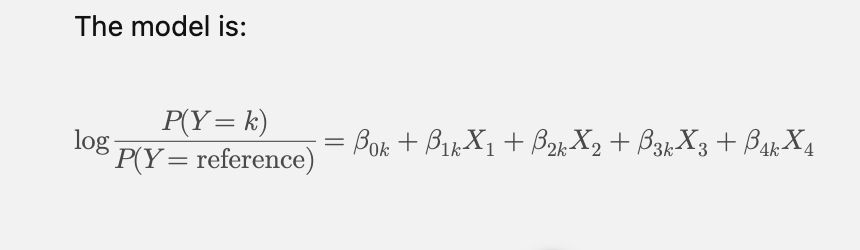

#DATA CLEAN : LVL 2.4
1) percent 10

2) percent 12

3) Dealing with Class X favourite marks and it's Marks and Class XII favourite marks and it's Marks

In [18]:
def average_range(range_str):
    lower, upper = map(float, range_str.split(' - '))
    return (lower + upper) / 2

In [19]:
def has_no_numbers(input_string):
    return not bool(re.search(r'\d', input_string))


In [20]:
df2['Percent_10'] = df2['Percent_10'].replace(r'60-70', '60 - 70')
df2['Percent_10'] = df2['Percent_10'].astype(str)
#print(df2['Percent_10'])
df2['Percent_10'] = df2['Percent_10'].apply(average_range)

df2['Percent_12'] = df2['Percent_12'].replace(r'60-70', '60 - 70')
df2['Percent_12'] = df2['Percent_12'].astype(str)
#print(df2['Percent_10'])
df2['Percent_12'] = df2['Percent_12'].apply(average_range)

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

In [21]:
# Extract the subject and marks from the 'fav_marks_XII' column
df2[['Favorite_Subject_10', 'Marks_10']] = df2['fav_marks_X'].str.extract(r'([A-Za-z]+)[\s:,\-(]+(\d+)')
df2[['Favorite_Subject_12', 'Marks_12']] = df2['fav_marks_XII'].str.extract(r'([A-Za-z]+)[\s:,\-(]+(\d+)')
#df2[['Favorite_Subject_12', 'Marks_12']] = df2['fav_marks_XII'].str.split('-', expand=True)

df2['Favorite_Subject_10'] = df2.apply(lambda row: row['fav_marks_X'] if has_no_numbers(row['fav_marks_X']) else row['Favorite_Subject_10'], axis=1)


# Convert 'Marks_12' to numeric, if necessary
df2['Marks_10'] = pd.to_numeric(df2['Marks_10'], errors='coerce')
df2['Marks_12'] = pd.to_numeric(df2['Marks_12'], errors='coerce')


In [22]:
df2=df2.drop('fav_marks_X', axis=1)
df2=df2.drop('fav_marks_XII', axis=1)

Subject_mapping2 = {
    'maths': 'mathematics',
    'math':'mathematics',
    'computerscience': 'computer science',
    #'amity university kolkata': 'amity university'
    }


df2['Favorite_Subject_10'] = df2['Favorite_Subject_10'].map(college_mapping).fillna(df2['Favorite_Subject_10'])
df2['Favorite_Subject_12'] = df2['Favorite_Subject_12'].map(college_mapping).fillna(df2['Favorite_Subject_12'])

In [23]:
df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)

df2['college_code'] = df2['College Name '].astype('category').cat.codes + 1

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

<ipython-input-23-0f63031faf2e>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


exp_salary -> @⁨Rishav Pedo⁩

proffesion -> @⁨Saunak SNU⁩

parent’s occupation -> me

parents occupation

In [24]:
df2['profession'] = df2['profession'].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
df2['profession'] = df2['profession'].replace(r'.*data analyst.*', 'data analyst', regex=True)
df2['profession'] = df2['profession'].replace(r'.*msc.*','academia')
df2['profession'] = df2['profession'].replace(r'.*sde.*','software development engineer')
df2['profession'] = df2['profession'].replace(r'.*entrepreneur.*', 'entrepreneurship', regex=True)
#df2['profession'] = df2['profession'].replace(r'.*data scientist, sports analyst.*', 'data analyst', regex=True)
df2['profession'] = df2['profession'].replace(r'.*commerce related.*', 'commercial', regex=True)
df2['profession'] = df2['profession'].replace(r'.*software developer.*', 'software development engineer', regex=True)
#df2['profession'] = df2['profession'].replace(r'.*.*', '', regex=True)




In [25]:
'''null_list = np.array(['not','haven','depends','no','don','na'])
for i in range(len(null_list)):
  df2['Expected_salary'] = df2['Expected_salary'].replace(null_list[i], np.nan,regex=True)

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)'''

"null_list = np.array(['not','haven','depends','no','don','na'])\nfor i in range(len(null_list)):\n  df2['Expected_salary'] = df2['Expected_salary'].replace(null_list[i], np.nan,regex=True)\n\ndf2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)"

In [26]:
#df2['Expected_salary'] = df2[df2['Expected_salary'].str.contains(r'\d', na=False)]
df2['Expected_salary'] = df2['Expected_salary'].astype(str)
df2['Expected_salary'] = df2['Expected_salary'].apply(lambda x: x if any(char.isdigit() for char in x) else np.nan)


In [27]:
print(df2.columns)

# Specify the new column order
new_column_order = ['index', 'Age Group', 'Gender','college_code', 'College Name ', 'Degree ', 'Subject','Percent_10','Favorite_Subject_10', 'Marks_10','Percent_12','Favorite_Subject_12', 'Marks_12','CGPA','co-curricular activity','profession', 'preffed sector','Expected_salary','Do you feel financially constrained while choosing your career in higher studies? ','Family_income', "Parent's occupation",
       'Spending', 'parents_influence', 'friend_influence', 'mentor_influence',
       'social_expectations', 'social_media_influence', 'personal_choice']

# Reorder DataFrame columns
df2 = df2[new_column_order]

df2.to_csv('/content/drive/MyDrive/pdf files/output.csv', index=False)

Index(['index', 'Age Group', 'Gender', 'College Name ', 'Degree ', 'Subject',
       'Percent_10', 'co-curricular activity', 'Percent_12', 'motivation',
       'satisfaction', 'easy', 'CGPA', 'profession', 'preffed sector',
       'Do you feel financially constrained while choosing your career in higher studies? ',
       'Expected_salary', 'Age', 'Family_income', 'Parent's occupation',
       'Spending', 'parents_influence', 'friend_influence', 'mentor_influence',
       'social_expectations', 'social_media_influence', 'personal_choice',
       'Favorite_Subject_10', 'Marks_10', 'Favorite_Subject_12', 'Marks_12',
       'college_code'],
      dtype='object', name=0)


# Data Repesentation 1

1) Gender

Gender
f    95
m    89
o     1
Name: count, dtype: int64
Sample Size:  185


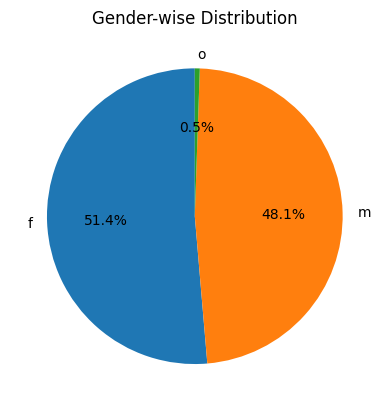

In [28]:
Gender_counts = df2['Gender'].value_counts()
print(Gender_counts)
print("Sample Size: ",total_frequency)
#------------------------------------------------------
Gender_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')  # Hide the y-label
plt.title('Gender-wise Distribution')
plt.show()

#Correlation

Simple and Multiple Correlation

In [29]:
df2['Family_income']=df2['Family_income'].astype(str)

df2['Family_income_coded'] = df2['Family_income'].apply(
    lambda x: 0 if x == 'below 3 lakhs' else
              1 if x == '3 -  7  lakhs' else
              2 if x == '7 - 10 lakhs' else
              3 if x == '10 - 12 lakhs' else
              4 if x == '12 - 15 lakhs' else 5)

correlation = df2['Spending'].corr(df2['Family_income_coded'])
print("Correlation b/w Family income and Amnt students are ready to invest in Higher Education:", correlation)


correlation2 = df2['Percent_10'].corr(df2['Percent_12'])
print("Correlation b/w Class 10 Avg. & Class 12 Avg.:", correlation2)


correlation3 = df2['Spending'].corr(df2['college_code'])
print("Correlation b/w Spending & Colleges :", correlation3)

Correlation b/w Family income and Amnt students are ready to invest in Higher Education: 0.3890507395411956
Correlation b/w Class 10 Avg. & Class 12 Avg.: 0.5082196689707311
Correlation b/w Spending & Colleges : 0.057326483006432685


In [30]:
def multiple_correlation(cgpa, percent_10, percent_12):
    # Calculate pairwise correlation coefficients
    r_Y_X1 = np.corrcoef(cgpa, percent_10)[0, 1]
    r_Y_X2 = np.corrcoef(cgpa, percent_12)[0, 1]
    r_X1_X2 = np.corrcoef(percent_10, percent_12)[0, 1]

    # Calculate multiple correlation coefficient
    numerator = (r_Y_X1**2 + r_Y_X2**2 - 2 * r_Y_X1 * r_Y_X2 * r_X1_X2)
    denominator = (1 - r_X1_X2**2)
    R_Y_X1X2 = np.sqrt(numerator / denominator) if denominator != 0 else np.nan  # To handle division by zero

    return R_Y_X1X2

In [31]:
#print(type(df2['CGPA']))
df2['CGPA'] = pd.to_numeric(df2['CGPA'], errors='coerce')
df2['Percent_10'] = pd.to_numeric(df2['Percent_10'], errors='coerce')
df2['Percent_12'] = pd.to_numeric(df2['Percent_12'], errors='coerce')


multiple_corr = multiple_correlation(df2['CGPA'], df2['Percent_10'], df2['Percent_12'])
print("Multiple Correlation (CGPA with Percent_10 and Percent_12):", multiple_corr)

Multiple Correlation (CGPA with Percent_10 and Percent_12): 0.25782828782388684


#Regression

In [32]:
# Define the independent variables (X) and the dependent variable (y)
X = df2[['Percent_10', 'Percent_12']]
y = df2['CGPA']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   CGPA   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     6.480
Date:                Sun, 08 Dec 2024   Prob (F-statistic):            0.00191
Time:                        09:36:37   Log-Likelihood:                -436.82
No. Observations:                 185   AIC:                             879.6
Df Residuals:                     182   BIC:                             889.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0668      2.074     -0.032      0.9

In [33]:
from scipy.stats import f_oneway



# Group the quantitative data by each category
#groups = [df[df['Category'] == category]['Numeric'] for category in df['Category'].unique()]
#anova_result = f_oneway(*groups)
#print("ANOVA F-statistic:", anova_result.statistic)
#print("ANOVA p-value:", anova_result.pvalue)